In [1]:
'''
    基本没开始
'''

import sys 
sys.path.append("../../common/map-API") 

import Amap_router

my_amaper = Amap_router.my_Amapper()

print(my_amaper.get_location("浙江省杭州市江干区彭埠街道Costa Coffee(杭州东站)杭州东站"))

[120.208252, 30.291027]


In [2]:
import GPS_trasfrom as GPS
import pandas as pd
import folium


list_wgs84=GPS.gcj02_to_wgs84(120.433019,30.233655)
airport_lon=round(list_wgs84[0],7)
airport_lat=round(list_wgs84[1],7)

airport_minlat=round(GPS.findNeighPosition(airport_lon,airport_lat,1.5).minlat,7)#机场2km
airport_maxlat=round(GPS.findNeighPosition(airport_lon,airport_lat,1.5).maxlat,7)
airport_minlng=round(GPS.findNeighPosition(airport_lon,airport_lat,1.5).minlng,7)
airport_maxlng=round(GPS.findNeighPosition(airport_lon,airport_lat,1.5).maxlng,7)


def get_lonlat(path):
    f =open(path,"r")
    data=f.read()
    tmp=''
    list1=[]
    for i in data:
        tmp=tmp+i
        if i==',' or i==';': 
            list1.append(float(tmp[:-1]))
            tmp=''
    list_lonlat=[]
    list_wgs84=[]
    for i in range(0,len(list1),2):
        list_tmp=[list1[i],list1[i+1]]
        list_wgs84.append(GPS.gcj02_to_wgs84(list1[i],list1[i+1]))
        list_tmp.reverse()
        list_lonlat.append(list_tmp)        
    return list_wgs84,list_lonlat
def folium_line(df,color):
    if color=='':
        color='red'
    line_map=folium.PolyLine(
        locations=df['latlon'].values.tolist(),
        color=color,
        weight=5,
    )
    return line_map 
def folium_circle(df,color):
    if color=='':
        color='red'
    list_lonlat=df['latlon'].iloc[0]
    plano=df['pla_no'].iloc[0]
    time=df['gps_time'].iloc[0]
    tool_tip= str(plano)+':'+str(time)+':'+str(list_lonlat),
    circle_map=folium.CircleMarker(
        location=list_lonlat,
        radius = 4, # define how big you want the circle markers to be
        tooltip =tool_tip,
        color =color,
        fill=True,
        fill_opacity=0.4
    )
    return circle_map
def folium_marker(df,color):
    if color=='':
        color='red'
    if df.shape[0]>1: 
        print('不能传入长度大于1的dataframe')
        return 0
    list_lonlat=df['latlon'].iloc[0]
    plano=df['pla_no'].iloc[0]
    time=df['gps_time'].iloc[0]
    if color=='orange':
        tool_tip='下车点:'+str(plano)+':'+str(time)+':'+str(list_lonlat)
        marker_map=folium.Marker(
        location=list_lonlat,
        tooltip = tool_tip,
        icon=folium.Icon(color=color,icon='glyphicon-arrow-down')
        )
    if color=='blue':
        tool_tip='上车点:'+str(plano)+':'+str(time)+':'+str(list_lonlat)
        marker_map=folium.Marker(
        location=list_lonlat,
        tooltip = tool_tip,
        icon=folium.Icon(color=color,icon='glyphicon-arrow-up')            
        )
    return marker_map


In [3]:
path1=r'C:\Users\zhengqiushi\Desktop\hik\21-09-01\data\萧山机场经纬度轮廓.txt'
#############################################################################
list_wgs84_airport,list_lonlat=get_lonlat(path1)

df_airport_lonlat=pd.DataFrame({'latlon':list_lonlat})
m= folium.Map(location=[airport_lat,airport_lon],
                      zoom_start=12,
                      tiles='http://wprd01.is.autonavi.com/appmaptile?x={x}&y={y}&z={z}&lang=zh_cn&size=1&scl=1&style=7',
                      attr="default")
line_map=folium_line(df_airport_lonlat,'red')
line_map.add_to(m)

# display(m)

In [4]:
from bs4 import BeautifulSoup
import re

import geopandas as gpd
import pyproj
from geopandas import GeoDataFrame
from geopandas import GeoSeries

from shapely.geometry import Polygon
from shapely.geometry import Point 
from shapely.geometry import LineString

########polygon中经纬度形式为 经度在前，维度在后
list_geo_polygon=[]
list_lonlat_tuple=[(x[1], x[0]) for x in list_lonlat]
list_lonlat_tuple
geo_polygon=Polygon(list_lonlat_tuple)

list_geo_polygon.append(geo_polygon)

geo_polygon_airport = gpd.GeoSeries(list_geo_polygon)

df_geo_polygon_airport=GeoDataFrame({'airport_name':['萧山国际机场']},geometry=geo_polygon_airport, crs="EPSG:4326")

# df_geo_polygon_airport.to_crs("4326")


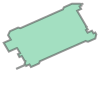

In [6]:
geo_polygon

In [7]:
import psycopg2
class my_PG:
    def __init__(self):
        self.conn=psycopg2.connect(dbname='hzzfd',user='hzzfd',password='hzzfd',port=5432,host='10.19.124.181')

    def query(self, sql):
        df=pd.read_sql(sql,con=self.conn)
        return df
my_pg = my_PG()

In [101]:


sql_airport= pd.read_csv(r"C:\Users\zhengqiushi\Desktop\hik\21-09-01\data\airport_0301_0902.csv")
#直接用vehi_run_20210301_taxi_43也可以，airport_accurate_data_0301已经过滤了一部分一整天都没去过机场的车辆

print(sql_airport.columns)

Index(['pla_no', 'longi', 'lati', 'gps_time', 'run_status'], dtype='object')


In [99]:
# sql_airport = sql_airport.sort_values('router_index')



In [102]:
print(len(sql_airport))

680469


In [105]:
## 截取萧山机场的坐标
# 整体清除 
sql_airport['point_lonlat']=sql_airport.apply(lambda x:Point(round(x.longi,6), round(x.lati,6)),axis =1)
cur_car_gps_total = GeoDataFrame(sql_airport, geometry=sql_airport['point_lonlat'], crs='EPSG:4326' )


In [110]:
# # 所有点记录与现有图形进行包含运算
df_airport_contains = gpd.sjoin(cur_car_gps_total, df_geo_polygon_airport, how="left", op='within')
# # 机场名为nan的被滤除，说明不在范围内
# df_airport_contains = df_airport_contains[~pd.isnull(df_airport_contains['airport_name'])]


In [104]:
df_airport_contains.to_csv(r"C:\Users\zhengqiushi\Desktop\hik\21-09-01\data\airport_0301_0902_xiaoshan.csv")

In [77]:
certain_ = df_airport_contains.groupby('router_index')

In [78]:
print(len(certain_.groups))

2473


In [89]:
car_plate_list = []
car_plate_df_list = []


## 截取萧山机场的坐标
for key, value in certain_:
    ### 坐标转换
    # value['point_lonlat']=value.apply(lambda x:Point(round(x.longi,6), round(x.lati,6)),axis =1)
    # cur_car_gps_total = GeoDataFrame(value, geometry=value['point_lonlat'], crs='EPSG:4326' )

    # # 所有点记录与现有图形进行包含运算
    # df_airport_contains = gpd.sjoin(cur_car_gps_total, df_geo_polygon_airport,how="left", op='within')
    # # 机场名为nan的被滤除，说明不在范围内
    # df_airport_contains = df_airport_contains[~pd.isnull(df_airport_contains['airport_name'])]

    # if len(df_airport_contains) > 0:
    #     pass
    # else:
    #     continue
    # # 清洗一下
    # # df_airport_contains = df_airport_contains.sort_values('gps_time')

    # # 保证是一开头, 且连续5个1 
    # cnt = 0    
    # continue_num = 5
    # for i, r in df_airport_contains.iterrows():
    #     if r['run_status'] != 1:
    #         break
    #     else:
    #         cnt += 1
    #     if cnt == continue_num:
    #         break
    if value['run_status'].values[-1] == 1:
        continue
    # if cnt < continue_num:
    #     continue
    # # 记录
    car_plate_list.append(key)
    car_plate_df_list.append(value)
    
    if len(car_plate_list) % 100 == 99:
        print(len(car_plate_list))
    # print(key)
    # print(df_airport_contains)
    # if len(car_plate_list) > 3:
    #     break





99
199
299
399
499


In [11]:
print(max(car_plate_df_list[0]['lati']), min(car_plate_df_list[0]['lati']))
print(max(car_plate_df_list[1]['lati']), min(car_plate_df_list[1]['lati']))
print(max(car_plate_df_list[2]['lati']), min(car_plate_df_list[2]['lati']))
print(max(car_plate_df_list[3]['lati']), min(car_plate_df_list[3]['lati']))

30.23946 30.227798
30.239292 30.227125
30.233 30.227388
30.239332 30.227533


In [90]:
import sys 
sys.path.append("../../common") 

import tools

def draw_route_taxi_status(
    san_map, src_pos, dst_pos, ret_route_Amap, run_status,  
    color_router = "#000000", start_tip = "start", end_tip = "end", router_tip = "router"):

    color = {
        1 : "#FF0000", # tools.randomcolor(),
        2 : "#00FF00"  # tools.randomcolor()
    }
    folium.Circle(radius=100,location=[src_pos[0], src_pos[1]], tooltip = start_tip,color = '#000000').add_to(san_map)
    folium.Circle(radius=100,location=[dst_pos[0], dst_pos[1]], tooltip = end_tip,color = '#666666').add_to(san_map)

    status_cnt = {
        1: 0, 2: 0
    }

    for i in range(0, len(ret_route_Amap)):
        if run_status[i] == 1:
            status_cnt[1] += 1
        else:
            status_cnt[2] += 1

    cur_tatus_cnt = {
        1: 0, 2: 0
    }

    cur_status_1 = 0; cut_status_2 = 0
    for i, per_point in enumerate(ret_route_Amap):
        if run_status[i] == 1:
            cur_tatus_cnt[1] += 1
        else:
            cur_tatus_cnt[2] += 1

        c_s = run_status[i]
        folium.Circle(radius=10, location=[per_point[0], per_point[1]],tooltip = router_tip,color=color[c_s], opacity= 1.5 - cur_tatus_cnt[c_s] * 1.0 / status_cnt[c_s]).add_to(san_map)
        if i > 0:
            folium.PolyLine([ret_route_Amap[i - 1], ret_route_Amap[i]],color=color[c_s], opacity= 1.5 - cur_tatus_cnt[c_s] * 1.0 / status_cnt[c_s]).add_to(san_map)
    # folium.PolyLine(ret_route_Amap,color=color_router).add_to(san_map)

In [94]:
# def devide_time_piece(input, output, thresh = 2 * 60 * 60):
#     '''
#     @params input dataframe
#     '''
    
#     # new_gps_pos_piece = []
#     # new_status_piece = []
#     new_df = pd.DataFrame()

#     cnt = -1
#     for i, r in input.iterrows():

#         cnt += 1
        

#         if cnt == 0 or (pd.to_datetime(r['gps_time']) - pd.to_datetime(last)).total_seconds() < thresh:
#             # 在阈值之内，继续添加
#             last = r['gps_time']
#             new_df = pd.concat([new_df, r], axis= 1)
#             # new_gps_pos_piece.append((r['longi'], r['lati']))
#             # new_status_piece.append(r['run_status'])

#             if cnt == 0:
#                 continue
#         else:
#             # 超过阈值了
#             last = r['gps_time']
#             output.append(new_df.T)
#             new_df = pd.DataFrame()
#             new_df = pd.concat([new_df, r], axis= 1)
#             # gps_pos.append(new_gps_pos_piece)
#             # new_gps_pos_piece.clear()

#             # run_status.append(new_status_piece)
#             # new_status_piece.clear()

#     if len(new_df) > 0:
#         output.append(new_df.T)

# new_car_plate_df_list = []

# for i in car_plate_df_list:
#     devide_time_piece(i, new_car_plate_df_list)
# print(len(new_car_plate_df_list))



1872


In [95]:
# filter_new_car_plate_df_list = []

# for i in new_car_plate_df_list:
#     # 保证是一开头, 且连续5个1   
#     cnt = 0    
#     continue_num = 5

#     for j, r in i.iterrows():
#         if r['run_status'] != 1:
#             break
#         else:
#             cnt += 1
#         if cnt == continue_num:
#             break

#     if cnt < continue_num:
#         continue
#     filter_new_car_plate_df_list.append(i)

# print(len(filter_new_car_plate_df_list))

1579


In [30]:
import constrast_between as drawer






# print(len(filter_new_car_plate_df_list[2]))
# print(filter_new_car_plate_df_list[2].columns)




# for i, per_router in enumerate(filter_new_car_plate_df_list):
#     if i < 3:
#         continue
#     loc_zip = list(zip(per_router["lati"], per_router["longi"]))
#     run_status = list(per_router['run_status'])
#     if len(loc_zip) > 0:
#         draw_route_taxi_status(my_map_.san_map, loc_zip[0], loc_zip[-1], loc_zip, run_status, router_tip = car_plate_list[i])
#         # my_map_.draw_route(loc_zip[0], loc_zip[-1], loc_zip, router_tip = car_plate_list[i]) # color_router = "#000000", start_tip = "start", end_tip = "end", router_tip = "router"
#     break



In [80]:

print(car_plate_df_list[0])

    per_id                router_index   pla_no       longi       lati  \
19      20  浙AAT7612021-03-01 10:56:37  浙AAT761  120.412025  30.228556   
20      21  浙AAT7612021-03-01 10:56:37  浙AAT761  120.414360  30.229380   
21      22  浙AAT7612021-03-01 10:56:37  浙AAT761  120.415085  30.228552   
22      23  浙AAT7612021-03-01 10:56:37  浙AAT761  120.418884  30.230213   
23      24  浙AAT7612021-03-01 10:56:37  浙AAT761  120.421135  30.231058   
24      25  浙AAT7612021-03-01 10:56:37  浙AAT761  120.421560  30.230207   
25      26  浙AAT7612021-03-01 10:56:37  浙AAT761  120.420730  30.229973   
26      27  浙AAT7612021-03-01 10:56:37  浙AAT761  120.420290  30.230460   
27      28  浙AAT7612021-03-01 10:56:37  浙AAT761  120.418870  30.229820   

               gps_time  run_status                  point_lonlat  \
19  2021-03-01 11:05:40           1  POINT (120.412025 30.228556)   
20  2021-03-01 11:06:07           1    POINT (120.41436 30.22938)   
21  2021-03-01 11:06:42           1  POINT (120.4150

In [91]:
take_guest_time = []
# car_plate_list = []
# car_plate_df_list = []
my_map_ = drawer.my_map_compare([120.3, 30.2], [120.3, 30.2])


for i, per_router in enumerate(car_plate_df_list):

    my_map_.draw_polygon(list_lonlat)

    loc_zip = list(zip(per_router["lati"], per_router["longi"]))
    run_status = list(per_router['run_status'])

    # 
    all_gps_time = list(per_router['gps_time'])
    in_time = pd.to_datetime(all_gps_time[0])

    # print(in_time)
    for j in range(0, len(run_status)):
        if j == 0:
            continue
        if run_status[j] != run_status[j - 1]  :
            out_time = pd.to_datetime(all_gps_time[j])
            
            delta_time = (out_time - in_time).total_seconds()
            if delta_time <= 0:
                break
            my_map_.add_point([loc_zip[j][1], loc_zip[j][0]])
            
            take_guest_time.append(delta_time)
            break

    if len(loc_zip) > 0:
        # pass
        draw_route_taxi_status(my_map_.san_map, loc_zip[0], loc_zip[-1], loc_zip, run_status, router_tip = car_plate_list[i])
        break # my_map_.draw_route(loc_zip[0], loc_zip[-1], loc_zip, router_tip = car_plate_list[i]) # color_router = "#000000", start_tip = "start", end_tip = "end", router_tip = "router"
        
    # a = input("input:")
    # print(a, type(int(a)))
    

    # if a == '1':
    #     break
    

    # break
    # if len(loc_zip) > 0:
    #     draw_route_taxi_status(my_map_.san_map, loc_zip[0], loc_zip[-1], loc_zip, run_status, router_tip = car_plate_list[i])
        # my_map_.draw_route(loc_zip[0], loc_zip[-1], loc_zip, router_tip = car_plate_list[i]) # color_router = "#000000", start_tip = "start", end_tip = "end", router_tip = "router"
    # break
display(my_map_.san_map)

# print(take_guest_time)



In [65]:
print(car_plate_df_list[100])

        per_id                router_index   pla_no       longi       lati  \
3939        27  浙AAT7612021-03-01 10:56:37  浙AAT761  120.420290  30.230460   
3938        26  浙AAT7612021-03-01 10:56:37  浙AAT761  120.420730  30.229973   
3937        25  浙AAT7612021-03-01 10:56:37  浙AAT761  120.421560  30.230207   
3936        24  浙AAT7612021-03-01 10:56:37  浙AAT761  120.421135  30.231058   
3935        23  浙AAT7612021-03-01 10:56:37  浙AAT761  120.418884  30.230213   
...        ...                         ...      ...         ...        ...   
679645  679646  浙AVT8482021-03-01 11:08:26  浙AVT848  120.419550  30.230207   
679646  679647  浙AVT8482021-03-01 11:08:26  浙AVT848  120.419550  30.230207   
679647  679648  浙AVT8482021-03-01 11:08:26  浙AVT848  120.419550  30.230207   
679648  679649  浙AVT8482021-03-01 11:08:26  浙AVT848  120.419550  30.230207   
679635  679636  浙AVT8482021-03-01 11:08:26  浙AVT848  120.419550  30.230207   

                   gps_time  run_status                  point_

0    1619.0
dtype: float64


<AxesSubplot:>

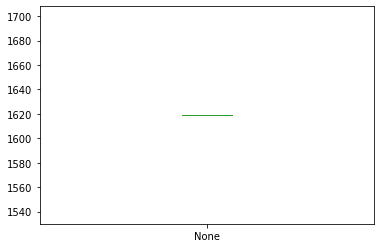

In [92]:
take_guest_time_series = pd.Series(take_guest_time)

print(take_guest_time_series)



take_guest_time_series.plot.box()

In [93]:
tmp = pd.read_csv(r"C:\Users\zhengqiushi\Desktop\hik\21-08-23\data\ods_july_only_hmap_result.csv")

C:\Users\zhengqiushi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [96]:
tmp = tmp[(tmp['zke_lch_jyqk'] > 3) & (tmp['Hmap_dist'] < 0)]

In [97]:
tmp.to_csv(r"C:\Users\zhengqiushi\Desktop\hik\21-08-23\data\ods_july_only_hmap_request_failed.csv")